In [36]:
!pip install pandas
!pip install dotenv
!pip install pymilvus
!pip install weaviate
!pip install weaviate.util
!pip install weaviate-client
!pip install "weaviate-client<4.0.0"



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\erict\PycharmProjects\vector-db-research-project\.venv\Lib\site-packages\IPython\utils\_process_win32.py:138: ResourceWarning: unclosed file <_io.BufferedWriter name=3>
  res = process_handler(cmd, _system_body)
C:\Users\erict\PycharmProjects\vector-db-research-project\.venv\Lib\site-packages\IPython\utils\_process_win32.py:138: ResourceWarning: unclosed file <_io.BufferedReader name=4>
  res = process_handler(cmd, _system_body)
C:\Users\erict\PycharmProjects\vector-db-research-project\.venv\Lib\site-packages\IPython\utils\_process_win32.py:138: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  res = process_handler(cmd, _system_body)



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement weaviate.util (from versions: none)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for weaviate.util



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Attempting uninstall: weaviate-client
    Found existing installation: weaviate-client 4.17.0
    Uninstalling weaviate-client-4.17.0:
      Successfully uninstalled weaviate-client-4.17.0



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv

# Vector DB clients
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection
import weaviate
from weaviate.util import generate_uuid5

load_dotenv()

# Paths to your datasets
DATASET_1K = "webscrapped_dataset/mit_ai_news_embeddings.csv"
DATASET_100K = "webscrapped_dataset/mit_ai_news_embeddings_expanded.csv"

# Load one to confirm shape
df = pd.read_csv(DATASET_1K)
print(df.shape)
df.head(3)


(1018, 392)


,Unnamed: 0,Published Date,Author,Source,Article Header,Sub_Headings,Article Body,Url,dim_0,dim_1,...,dim_374,dim_375,dim_376,dim_377,dim_378,dim_379,dim_380,dim_381,dim_382,dim_383
0,0,"July 7, 2023",Adam Zewe,MIT News Office,Learning the language of molecules to predict ...,This AI system only needs a small amount of da...,['Discovering new materials and drugs typicall...,https://news.mit.edu/2023/learning-language-mo...,-0.094391,-0.074629,...,-0.020992,0.061577,-0.032413,-0.065120,0.038331,-0.015468,0.018724,-0.039506,0.023896,-0.038896
1,1,"July 6, 2023",Alex Ouyang,Abdul Latif Jameel Clinic for Machine Learning...,MIT scientists build a system that can generat...,"BioAutoMATED, an open-source, automated machin...",['Is it possible to build machine-learning mod...,https://news.mit.edu/2023/bioautomated-open-so...,-0.021315,0.016696,...,0.043760,0.087711,0.036174,-0.058537,0.025160,0.019509,0.036880,-0.019031,-0.048487,-0.011607
2,2,"June 30, 2023",Jennifer Michalowski,McGovern Institute for Brain Research,"When computer vision works more like a brain, ...",Training artificial neural networks with data ...,"['From cameras to self-driving cars, many of t...",https://news.mit.edu/2023/when-computer-vision...,-0.079330,-0.030145,...,-0.012111,-0.036757,0.105021,-0.130547,-0.047330,0.076058,0.055008,0.058025,0.025629,-0.058450


In [11]:
# Load the dataset
df = pd.read_csv(DATASET_1K)
print("Dataset shape:", df.shape)

# Identify text and embedding columns
text_col = "Article Body"  # or whichever text you want to search
embedding_cols = [f"dim_{i}" for i in range(384)]

# Extract text and embeddings
texts = df[text_col].fillna("").tolist()
embeddings = df[embedding_cols].values.tolist()

print(f"Loaded {len(texts)} texts and {len(embeddings)} embeddings.")


Dataset shape: (1018, 392)
Loaded 1018 texts and 1018 embeddings.


In [21]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility
import os
import time
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

MILVUS_HOST = os.getenv("MILVUS_HOST", "localhost")
MILVUS_PORT = os.getenv("MILVUS_PORT", "19530")
MILVUS_COLLECTION = os.getenv("MILVUS_COLLECTION", "ai_news_1k")

# 1️⃣ Connect to Milvus
connections.connect(alias="default", host=MILVUS_HOST, port=MILVUS_PORT)
print("✓ Connected to Milvus")

# 2️⃣ Drop old collection if it exists
if utility.has_collection(MILVUS_COLLECTION):
    print(f"Dropping old collection '{MILVUS_COLLECTION}' to apply schema changes...")
    utility.drop_collection(MILVUS_COLLECTION)

# 3️⃣ Define schema (VARCHAR length extended)
fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name="content", dtype=DataType.VARCHAR, max_length=20000),
    FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=384),
]
schema = CollectionSchema(fields, description="AI News embeddings")

# 4️⃣ Create collection
collection = Collection(name=MILVUS_COLLECTION, schema=schema)
print("✓ Created new Milvus collection with 20k char text limit.")

# 5️⃣ Insert data with timing
batch_size = 1000
start_time = time.time()
total_inserted = 0

for i in range(0, len(embeddings), batch_size):
    batch_texts = texts[i:i+batch_size]
    batch_vectors = embeddings[i:i+batch_size]

    # Each insert must match schema order (id auto, so skip)
    collection.insert([batch_texts, batch_vectors])

    total_inserted += len(batch_vectors)
    print(f"Inserted {total_inserted} / {len(embeddings)} records")

collection.flush()

elapsed = time.time() - start_time
rows_per_sec = total_inserted / elapsed

print(f"✓ Data committed to Milvus in {elapsed:.2f}s ({rows_per_sec:.2f} rows/sec).")


✓ Connected to Milvus
Dropping old collection 'documents' to apply schema changes...
✓ Created new Milvus collection with 20k char text limit.
Inserted 1000 / 1018 records
Inserted 1018 / 1018 records
✓ Data committed to Milvus in 5.77s (176.57 rows/sec).


In [11]:
from pymilvus import connections, Collection, utility
import os

# --- Connect to Milvus ---
MILVUS_HOST = os.getenv("MILVUS_HOST", "localhost")
MILVUS_PORT = os.getenv("MILVUS_PORT", "19530")
MILVUS_COLLECTION = os.getenv("MILVUS_COLLECTION", "ai_news_1k")

connections.connect(alias="default", host=MILVUS_HOST, port=MILVUS_PORT)
print("✓ Connected to Milvus")

# --- Ensure the collection exists ---
if not utility.has_collection(MILVUS_COLLECTION):
    raise RuntimeError(
        f"Collection '{MILVUS_COLLECTION}' not found! "
        f"Run the insertion cell first to create it."
    )

collection = Collection(MILVUS_COLLECTION)
print(f"✓ Loaded collection schema: {MILVUS_COLLECTION}")


✓ Connected to Milvus
✓ Loaded collection schema: documents


In [4]:
import weaviate
print("Weaviate version actually loaded:", weaviate.__version__)
print("Loaded from:", weaviate.__file__)


Weaviate version actually loaded: 3.26.7
Loaded from: C:\Users\erict\PycharmProjects\vector-db-research-project\.venv\Lib\site-packages\weaviate\__init__.py


In [1]:
!pip uninstall -y weaviate weaviate-client

In [58]:
!pip list | findstr weaviate


In [3]:
!pip install weaviate-client==3.26.7

  Using cached weaviate_client-3.26.7-py3-none-any.whl.metadata (3.4 kB)
Using cached weaviate_client-3.26.7-py3-none-any.whl (120 kB)



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import weaviate
import pandas as pd
import os
import time
from dotenv import load_dotenv

load_dotenv()

WEAVIATE_URL = os.getenv("WEAVIATE_URL", "http://localhost:8084")
WEAVIATE_CLASS = os.getenv("WEAVIATE_CLASS", "Document")

# ✅ Connect to Weaviate (v3 syntax)
client = weaviate.Client(url=WEAVIATE_URL)
print("✓ Connected to Weaviate")

# Drop class if exists
if client.schema.exists(WEAVIATE_CLASS):
    client.schema.delete_class(WEAVIATE_CLASS)
    print(f"Dropped old class '{WEAVIATE_CLASS}'")

# Define schema
schema = {
    "classes": [
        {
            "class": WEAVIATE_CLASS,
            "description": "AI News 1K Embeddings",
            "vectorizer": "none",
            "vectorIndexType": "hnsw",
            "vectorIndexConfig": {"efConstruction": 128, "M": 64},
            "properties": [
                {
                    "name": "content",
                    "dataType": ["text"],
                    "description": "News article content",
                },
            ],
        }
    ]
}

# Create new class
client.schema.create(schema)
print(f"✓ Created Weaviate class '{WEAVIATE_CLASS}'")

# === Insert dataset ===
DATASET_1K = "webscrapped_dataset/mit_ai_news_embeddings.csv"
df = pd.read_csv(DATASET_1K)
text_col = "Article Body"
embedding_cols = [f"dim_{i}" for i in range(384)]

texts = df[text_col].fillna("").tolist()
embeddings = df[embedding_cols].values.tolist()

batch_size = 100
start = time.time()
with client.batch(batch_size=batch_size) as batch:
    for i, (text, vector) in enumerate(zip(texts, embeddings)):
        batch.add_data_object(
            data_object={"content": text},
            class_name=WEAVIATE_CLASS,
            vector=vector,
        )
        if (i + 1) % 100 == 0:
            print(f"Inserted {i + 1}/{len(texts)} docs")

elapsed = time.time() - start
print(f"Inserted {len(texts)} docs in {elapsed:.2f}s ({len(texts)/elapsed:.2f} docs/sec)")


✓ Connected to Weaviate
Dropped old class 'Document'
✓ Created Weaviate class 'Document'
Inserted 100/1018 docs
Inserted 200/1018 docs
Inserted 300/1018 docs
Inserted 400/1018 docs
Inserted 500/1018 docs
Inserted 600/1018 docs
Inserted 700/1018 docs
Inserted 800/1018 docs
Inserted 900/1018 docs
Inserted 1000/1018 docs
Inserted 1018 docs in 26.37s (38.60 docs/sec)


In [12]:
import numpy as np
import time, random
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from pymilvus import Collection

# --- Parameters ---
n_queries = 10
k = 10
model = SentenceTransformer("all-MiniLM-L6-v2")

# --- Prepare query set ---
query_indices = random.sample(range(len(texts)), n_queries)
query_texts = [texts[i] for i in query_indices]
query_embeddings = model.encode(query_texts, show_progress_bar=False)

# --- Compute ground truth (cosine similarity) ---
cosine_sim = cosine_similarity(query_embeddings, embeddings)
ground_truth_indices = np.argsort(-cosine_sim, axis=1)[:, :k]
print(f"Prepared {n_queries} queries (k={k})")

collection = Collection("documents")

# =========================================================
# 1️⃣ Exact Search (FLAT index)
# =========================================================
print("\n=== Milvus Exact Search (FLAT Index) ===")
try:
    collection.release()
    collection.drop_index()
except Exception:
    pass

collection.create_index(
    field_name="embedding",
    index_params={"index_type": "FLAT", "metric_type": "COSINE", "params": {}}
)
collection.load()

latencies, recalls = [], []
for qi, q_emb in enumerate(tqdm(query_embeddings)):
    t0 = time.time()
    results = collection.search(
        data=[q_emb.tolist()],
        anns_field="embedding",
        param={"metric_type": "COSINE"},
        limit=k,
        output_fields=["content"]
    )
    latencies.append(time.time() - t0)

    # Retrieved IDs (or texts) for recall computation
    retrieved_texts = [hit.entity.get("content") for hit in results[0]]

    # Ground truth text for this query
    gt_texts = [texts[idx] for idx in ground_truth_indices[qi]]

    # Recall@k = intersection / k
    intersection = len(set(retrieved_texts) & set(gt_texts))
    recall = intersection / k
    recalls.append(recall)

flat_latency = np.mean(latencies)
flat_throughput = 1 / flat_latency
flat_recall = np.mean(recalls)

print(f"Average Latency: {flat_latency*1000:.2f} ms/query")
print(f"Throughput: {flat_throughput:.2f} queries/sec")
print(f"Average Recall@{k}: {flat_recall:.2f}")

# =========================================================
# 2️⃣ ANN Search (HNSW)
# =========================================================
print("\n=== Milvus ANN Search (HNSW) ===")
collection.release()
collection.drop_index()

collection.create_index(
    field_name="embedding",
    index_params={
        "index_type": "HNSW",
        "metric_type": "COSINE",
        "params": {"M": 16, "efConstruction": 200}
    }
)
collection.load()

latencies, recalls = [], []
for qi, q_emb in enumerate(tqdm(query_embeddings)):
    t0 = time.time()
    results = collection.search(
        data=[q_emb.tolist()],
        anns_field="embedding",
        param={"ef": 32},  # smaller ef for approximate search
        limit=k,
        output_fields=["content"]
    )
    latencies.append(time.time() - t0)

    # Retrieved and ground truth texts
    retrieved_texts = [hit.entity.get("content") for hit in results[0]]
    gt_texts = [texts[idx] for idx in ground_truth_indices[qi]]

    intersection = len(set(retrieved_texts) & set(gt_texts))
    recall = intersection / k
    recalls.append(recall)

hnsw_latency = np.mean(latencies)
hnsw_throughput = 1 / hnsw_latency
hnsw_recall = np.mean(recalls)

print(f"Average Latency: {hnsw_latency*1000:.2f} ms/query")
print(f"Throughput: {hnsw_throughput:.2f} queries/sec")
print(f"Average Recall@{k}: {hnsw_recall:.2f}")


Prepared 10 queries (k=10)

=== Milvus Exact Search (FLAT Index) ===


100%|██████████| 10/10 [00:00<00:00, 23.69it/s]


Average Latency: 41.51 ms/query
Throughput: 24.09 queries/sec
Average Recall@10: 1.00

=== Milvus ANN Search (HNSW) ===


100%|██████████| 10/10 [00:00<00:00, 13.31it/s]

Average Latency: 74.53 ms/query
Throughput: 13.42 queries/sec
Average Recall@10: 1.00


In [19]:
import numpy as np
import time, random
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import weaviate
import pandas as pd
import os

# --- Parameters ---
n_queries = 10
k = 10
model = SentenceTransformer("all-MiniLM-L6-v2")

# --- Load same dataset used in Weaviate ---
DATASET_1K = "webscrapped_dataset/mit_ai_news_embeddings.csv"
df = pd.read_csv(DATASET_1K)
text_col = "Article Body"
embedding_cols = [f"dim_{i}" for i in range(384)]

texts = df[text_col].fillna("").tolist()
embeddings = df[embedding_cols].values.tolist()

# --- Prepare query set ---
query_indices = random.sample(range(len(texts)), n_queries)
query_texts = [texts[i] for i in query_indices]
query_embeddings = model.encode(query_texts, show_progress_bar=False)

# --- Compute ground truth using cosine similarity ---
cosine_sim = cosine_similarity(query_embeddings, embeddings)
ground_truth_indices = np.argsort(-cosine_sim, axis=1)[:, :k]
print(f"Prepared {n_queries} queries (k={k})")

# --- Connect to Weaviate ---
WEAVIATE_URL = os.getenv("WEAVIATE_URL", "http://localhost:8084")
client = weaviate.Client(WEAVIATE_URL)
print("✓ Connected to Weaviate")

# --- Helper for v3/v4 responses ---
def extract_docs(result):
    docs = result.get("data", {}).get("Get", {}).get("Document", [])
    if not docs:
        docs = result.get("Get", {}).get("Document", [])
    return docs or []

# =========================================================
# 1️⃣ Exact Search (high efSearch to simulate FLAT)
# =========================================================
print("\n=== Weaviate Exact Search (simulated FLAT) ===")

latencies, recalls = [], []
for qi, q_emb in enumerate(tqdm(query_embeddings)):
    t0 = time.time()
    result = (
        client.query
        .get("Document", ["content"])  # ✅ correct field name
        .with_near_vector({"vector": q_emb.tolist(), "ef": 128})  # high ef for high recall
        .with_limit(k)
        .with_additional(["distance"])
        .do()
    )
    latencies.append(time.time() - t0)

    docs = extract_docs(result)
    retrieved_texts = [item["content"] for item in docs]
    gt_texts = [texts[idx] for idx in ground_truth_indices[qi]]

    intersection = len(set(retrieved_texts) & set(gt_texts))
    recalls.append(intersection / k)

flat_latency = np.mean(latencies)
flat_throughput = 1 / flat_latency
flat_recall = np.mean(recalls)

print(f"Average Latency: {flat_latency*1000:.2f} ms/query")
print(f"Throughput: {flat_throughput:.2f} queries/sec")
print(f"Average Recall@{k}: {flat_recall:.2f}")

# =========================================================
# 2️⃣ ANN Search (lower efSearch for speed)
# =========================================================
print("\n=== Weaviate ANN Search (HNSW, ef=32) ===")

latencies, recalls = [], []
for qi, q_emb in enumerate(tqdm(query_embeddings)):
    t0 = time.time()
    result = (
        client.query
        .get("Document", ["content"])
        .with_near_vector({"vector": q_emb.tolist(), "ef": 32})
        .with_limit(k)
        .with_additional(["distance"])
        .do()
    )
    latencies.append(time.time() - t0)

    docs = extract_docs(result)
    retrieved_texts = [item["content"] for item in docs]
    gt_texts = [texts[idx] for idx in ground_truth_indices[qi]]

    intersection = len(set(retrieved_texts) & set(gt_texts))
    recalls.append(intersection / k)

hnsw_latency = np.mean(latencies)
hnsw_throughput = 1 / hnsw_latency
hnsw_recall = np.mean(recalls)

print(f"Average Latency: {hnsw_latency*1000:.2f} ms/query")
print(f"Throughput: {hnsw_throughput:.2f} queries/sec")
print(f"Average Recall@{k}: {hnsw_recall:.2f}")


Prepared 10 queries (k=10)
✓ Connected to Weaviate

=== Weaviate Exact Search (simulated FLAT) ===


100%|██████████| 10/10 [00:00<00:00, 27.52it/s]


Average Latency: 35.88 ms/query
Throughput: 27.87 queries/sec
Average Recall@10: 1.00

=== Weaviate ANN Search (HNSW, ef=32) ===


100%|██████████| 10/10 [00:00<00:00, 16.35it/s]

Average Latency: 60.63 ms/query
Throughput: 16.49 queries/sec
Average Recall@10: 1.00


In [23]:
import os
import weaviate
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Read Weaviate config from environment
WEAVIATE_URL = os.getenv("WEAVIATE_URL")
WEAVIATE_CLASS = os.getenv("WEAVIATE_CLASS", "Document")

print("\nCleaning Weaviate...")

try:
    # Connect to Weaviate instance
    client = weaviate.Client(WEAVIATE_URL)

    # Check if class exists and delete
    if client.schema.exists(WEAVIATE_CLASS):
        client.schema.delete_class(WEAVIATE_CLASS)
        print(f"Deleted Weaviate class '{WEAVIATE_CLASS}'.")
    else:
        print(f"Weaviate class '{WEAVIATE_CLASS}' not found — skipping deletion.")

    # Recreate empty class schema
    schema = {
        "class": WEAVIATE_CLASS,
        "description": "A class for document embeddings",
        "vectorizer": "none",
        "properties": [
            {"name": "title", "dataType": ["text"]},
            {"name": "body", "dataType": ["text"]},
            {"name": "url", "dataType": ["text"]},
            {"name": "embedding", "dataType": ["number[]"]}
        ]
    }

    client.schema.create_class(schema)
    print(f"Recreated empty Weaviate class '{WEAVIATE_CLASS}'.")

except Exception as e:
    print(f"Weaviate error: {e}")



Cleaning Weaviate...
Deleted Weaviate class 'Document'.
Recreated empty Weaviate class 'Document'.


In [24]:
from pymilvus import connections, utility, FieldSchema, CollectionSchema, DataType, Collection

print("\nCleaning Milvus...")

try:
    connections.connect("default", host=MILVUS_HOST, port=MILVUS_PORT)

    # Drop old collection if exists
    if utility.has_collection(MILVUS_COLLECTION):
        utility.drop_collection(MILVUS_COLLECTION)
        print(f"Deleted Milvus collection '{MILVUS_COLLECTION}'.")
    else:
        print(f"Milvus collection '{MILVUS_COLLECTION}' not found — skipping deletion.")

    # Define schema for recreation
    fields = [
        FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
        FieldSchema(name="title", dtype=DataType.VARCHAR, max_length=512),
        FieldSchema(name="body", dtype=DataType.VARCHAR, max_length=2048),
        FieldSchema(name="url", dtype=DataType.VARCHAR, max_length=512),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=384)
    ]
    schema = CollectionSchema(fields=fields, description="Document embeddings collection")

    # Create new collection
    collection = Collection(name=MILVUS_COLLECTION, schema=schema)
    print(f"Recreated empty Milvus collection '{MILVUS_COLLECTION}'.")

except Exception as e:
    print(f"Milvus error: {e}")



Cleaning Milvus...
Deleted Milvus collection 'documents'.
Recreated empty Milvus collection 'documents'.


In [27]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv
from pymilvus import (
    connections, utility, FieldSchema, CollectionSchema, DataType, Collection
)

# === Load .env ===
load_dotenv()
MILVUS_HOST = os.getenv("MILVUS_HOST", "192.168.195.69")
MILVUS_PORT = os.getenv("MILVUS_PORT", "19530")
MILVUS_COLLECTION = os.getenv("MILVUS_COLLECTION", "documents")

# === Re-declare and load expanded dataset ===
df = pd.read_csv("webscrapped_dataset/mit_ai_news_embeddings_expanded.csv")
vector_cols = [c for c in df.columns if c.startswith("dim_")]
vectors = df[vector_cols].values.astype("float32")

print(f"Loaded {len(vectors)} vectors ({len(vector_cols)} dimensions each)")

# Optional safety: truncate long text fields
MAX_BODY_LEN = 65000
MAX_TITLE_LEN = 5000
MAX_URL_LEN = 2000

df["Article Body"] = df["Article Body"].astype(str).str.slice(0, MAX_BODY_LEN)
df["Article Header"] = df["Article Header"].astype(str).str.slice(0, MAX_TITLE_LEN)
df["Url"] = df["Url"].astype(str).str.slice(0, MAX_URL_LEN)

# === Connect to Milvus ===
print("\n=== Milvus Insert Benchmark ===")
connections.connect("default", host=MILVUS_HOST, port=MILVUS_PORT)

# Delete existing collection if it exists
if utility.has_collection(MILVUS_COLLECTION):
    utility.drop_collection(MILVUS_COLLECTION)
    print(f"Dropped old Milvus collection '{MILVUS_COLLECTION}'.")

# Define schema (safe max lengths)
fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name="title", dtype=DataType.VARCHAR, max_length=MAX_TITLE_LEN),
    FieldSchema(name="body", dtype=DataType.VARCHAR, max_length=MAX_BODY_LEN),
    FieldSchema(name="url", dtype=DataType.VARCHAR, max_length=MAX_URL_LEN),
    FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=len(vector_cols))
]
schema = CollectionSchema(fields=fields, description="Document embeddings collection")

# Create collection
collection = Collection(name=MILVUS_COLLECTION, schema=schema)
print(f"Created new Milvus collection '{MILVUS_COLLECTION}'.")

# === Insert in batches ===
batch_size = 1000
latencies = []
start_total = time.time()

for i in tqdm(range(0, len(df), batch_size), desc="Milvus inserts"):
    batch = df.iloc[i:i+batch_size]
    batch_vectors = vectors[i:i+batch_size]

    t0 = time.time()
    collection.insert([
        batch["Article Header"].tolist(),
        batch["Article Body"].tolist(),
        batch["Url"].tolist(),
        batch_vectors.tolist()
    ])
    latencies.append(time.time() - t0)

end_total = time.time()
total_time = end_total - start_total
throughput = len(df) / total_time
avg_latency = np.mean(latencies)

# Flush to ensure persistence
collection.flush()

print(f"\nInserted {len(df)} docs in {total_time:.2f}s")
print(f"Average batch latency: {avg_latency:.2f}s")
print(f"Throughput: {throughput:.2f} docs/sec")


Loaded 101800 vectors (384 dimensions each)

=== Milvus Insert Benchmark ===
Dropped old Milvus collection 'documents'.
Created new Milvus collection 'documents'.


Milvus inserts: 100%|██████████| 102/102 [02:53<00:00,  1.71s/it]



Inserted 101800 docs in 173.92s
Average batch latency: 1.70s
Throughput: 585.32 docs/sec


In [29]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv
import weaviate

# === Load .env ===
load_dotenv()
WEAVIATE_URL = os.getenv("WEAVIATE_URL", "http://192.168.195.69:8084")
WEAVIATE_CLASS = os.getenv("WEAVIATE_CLASS", "Document")

# === Load your dataset ===
df = pd.read_csv("webscrapped_dataset/mit_ai_news_embeddings_expanded.csv")
vector_cols = [c for c in df.columns if c.startswith("dim_")]
vectors = df[vector_cols].values.astype("float32")

print(f"Loaded {len(vectors)} vectors ({len(vector_cols)} dimensions each)")

# === Connect to Weaviate ===
client = weaviate.Client(WEAVIATE_URL)

print("\n=== Weaviate Insert Benchmark ===")

# 🧹 Clean up existing class if exists
try:
    if client.schema.exists(WEAVIATE_CLASS):
        client.schema.delete_class(WEAVIATE_CLASS)
        print(f"Deleted old class '{WEAVIATE_CLASS}'.")
except Exception as e:
    print(f"Could not delete class (likely absent or locked): {e}")

# === Define schema ===
schema = {
    "class": WEAVIATE_CLASS,
    "description": "A class for document embeddings",
    "vectorizer": "none",  # we provide our own embeddings
    "properties": [
        {"name": "title", "dataType": ["text"]},
        {"name": "body", "dataType": ["text"]},
        {"name": "url", "dataType": ["text"]}
    ]
}

# Recreate class
try:
    client.schema.create_class(schema)
    print(f"Created class '{WEAVIATE_CLASS}'.")
except Exception as e:
    print(f"Error creating schema: {e}")

# === Insert in batches ===
batch_size = 100
latencies = []
start_total = time.time()

with client.batch as batch:
    batch.batch_size = batch_size
    for i in tqdm(range(0, len(df)), desc="Weaviate inserts"):
        data = {
            "title": df.iloc[i]["Article Header"],
            "body": df.iloc[i]["Article Body"],
            "url": df.iloc[i]["Url"]
        }
        vector = vectors[i].tolist()
        t0 = time.time()
        batch.add_data_object(data_object=data, class_name=WEAVIATE_CLASS, vector=vector)
        latencies.append(time.time() - t0)

end_total = time.time()
total_time = end_total - start_total
throughput = len(df) / total_time
avg_latency = np.mean(latencies)

print(f"\nInserted {len(df)} docs in {total_time:.2f}s")
print(f"Average object insert latency: {avg_latency:.4f}s")
print(f"Throughput: {throughput:.2f} docs/sec")


Loaded 101800 vectors (384 dimensions each)

=== Weaviate Insert Benchmark ===
🗑️ Deleted old class 'Document'.
Created class 'Document'.


Weaviate inserts: 100%|██████████| 101800/101800 [27:20<00:00, 62.07it/s] 



Inserted 101800 docs in 1640.30s
Average object insert latency: 0.0154s
Throughput: 62.06 docs/sec


In [36]:
import numpy as np
import time
from tqdm import tqdm
from pymilvus import connections, Collection, utility

# === Config ===
k = 10
MILVUS_COLLECTION = "documents"

# === Connect to Milvus ===
connections.connect("default", host="192.168.195.69", port="19530")
collection = Collection(MILVUS_COLLECTION)

# === Ensure index exists (create if missing) ===
indexes = utility.list_indexes(collection_name=MILVUS_COLLECTION)
if not indexes:
    print("No index found — creating IVF_FLAT index...")
    collection.create_index(
        field_name="embedding",
        index_params={
            "index_type": "IVF_FLAT",  # You can use "HNSW" as well based on research
            "metric_type": "L2",
            "params": {"nlist": 1024}
        }
    )
    print("Index created successfully.")
else:
    print(f"Found existing index: {indexes}")

# === Load collection into memory ===
print("Loading Milvus collection into memory...")
collection.load()

latencies, recalls = [], []

print("\n=== Milvus ANN Recall Benchmark ===")

for qi, q_emb in enumerate(tqdm(query_embeddings, desc="Milvus queries")):
    t0 = time.time()
    res = collection.search(
        data=[q_emb.tolist()],
        anns_field="embedding",
        param={"metric_type": "L2", "params": {"nprobe": 10}},
        limit=k,
        output_fields=["title"]
    )
    t1 = time.time()
    latencies.append(t1 - t0)

    retrieved_titles = [hit.entity.get("title") for hit in res[0]]
    gt_titles = [df.iloc[i]["Article Header"] for i in ground_truth_indices[qi]]
    recall = len(set(retrieved_titles) & set(gt_titles)) / k
    recalls.append(recall)

print(f"\nMilvus ANN - Avg latency: {np.mean(latencies)*1000:.2f} ms, "
      f"Throughput: {1/np.mean(latencies):.2f} q/s, "
      f"Avg Recall@{k}: {np.mean(recalls):.2f}")


Found existing index: ['embedding']
Loading Milvus collection into memory...

=== Milvus ANN Recall Benchmark ===


Milvus queries: 100%|██████████| 10/10 [00:00<00:00, 51.18it/s]


Milvus ANN - Avg latency: 16.06 ms, Throughput: 62.26 q/s, Avg Recall@10: 0.10


In [31]:
import numpy as np
import time
from tqdm import tqdm
import weaviate

# === Config ===
k = 10
WEAVIATE_URL = "http://192.168.195.69:8084"
WEAVIATE_CLASS = "Document"

client = weaviate.Client(WEAVIATE_URL)

latencies, recalls = [], []

print("\n=== Weaviate ANN Recall Benchmark ===")

for qi, q_emb in enumerate(tqdm(query_embeddings, desc="Weaviate queries")):
    t0 = time.time()
    res = (
        client.query.get(WEAVIATE_CLASS, ["title"])
        .with_near_vector({"vector": q_emb.tolist()})
        .with_limit(k)
        .do()
    )
    t1 = time.time()
    latencies.append(t1 - t0)

    # Parse results
    hits = res.get("data", {}).get("Get", {}).get(WEAVIATE_CLASS, [])
    retrieved_titles = [h["title"] for h in hits if "title" in h]

    gt_titles = [df.iloc[i]["Article Header"] for i in ground_truth_indices[qi]]
    recall = len(set(retrieved_titles) & set(gt_titles)) / k
    recalls.append(recall)

print(f"\nWeaviate ANN - Avg latency: {np.mean(latencies)*1000:.2f} ms, "
      f"Throughput: {1/np.mean(latencies):.2f} q/s, "
      f"Avg Recall@{k}: {np.mean(recalls):.2f}")



=== Weaviate ANN Recall Benchmark ===


Weaviate queries: 100%|██████████| 10/10 [00:00<00:00, 50.75it/s]


Weaviate ANN - Avg latency: 17.09 ms, Throughput: 58.52 q/s, Avg Recall@10: 0.10


In [ ]:
import os
from dotenv import load_dotenv
from pymilvus import connections, utility
import weaviate

# === Load .env ===
load_dotenv()

# Milvus config
MILVUS_HOST = os.getenv("MILVUS_HOST", "192.168.195.69")
MILVUS_PORT = os.getenv("MILVUS_PORT", "19530")
MILVUS_COLLECTION = os.getenv("MILVUS_COLLECTION", "documents")

# Weaviate config
WEAVIATE_URL = os.getenv("WEAVIATE_URL", "http://192.168.195.69:8084")
WEAVIATE_CLASS = os.getenv("WEAVIATE_CLASS", "Document")

print("Starting full vector DB cleanup...\n")

# === Milvus Cleanup ===
try:
    connections.connect("default", host=MILVUS_HOST, port=MILVUS_PORT)
    if utility.has_collection(MILVUS_COLLECTION):
        utility.drop_collection(MILVUS_COLLECTION)
        print(f"Dropped Milvus collection '{MILVUS_COLLECTION}'.")
    else:
        print(f"Milvus collection '{MILVUS_COLLECTION}' not found — skipping.")
except Exception as e:
    print(f"Milvus cleanup error: {e}")

# === Weaviate Cleanup ===
try:
    client = weaviate.Client(WEAVIATE_URL)
    if client.schema.exists(WEAVIATE_CLASS):
        client.schema.delete_class(WEAVIATE_CLASS)
        print(f"Dropped Weaviate class '{WEAVIATE_CLASS}'.")
    else:
        print(f"ℹ️ Weaviate class '{WEAVIATE_CLASS}' not found — skipping.")
except Exception as e:
    print(f"Weaviate cleanup error: {e}")

print("\nBoth databases have been reset — ready for fresh inserts.")


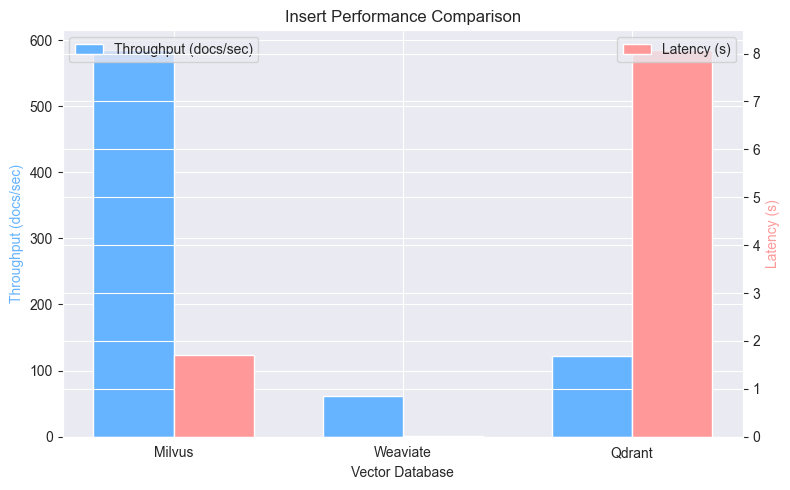

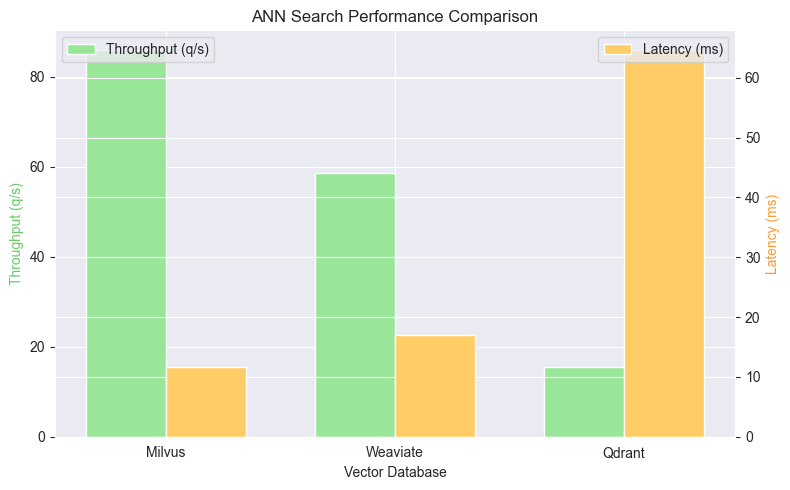

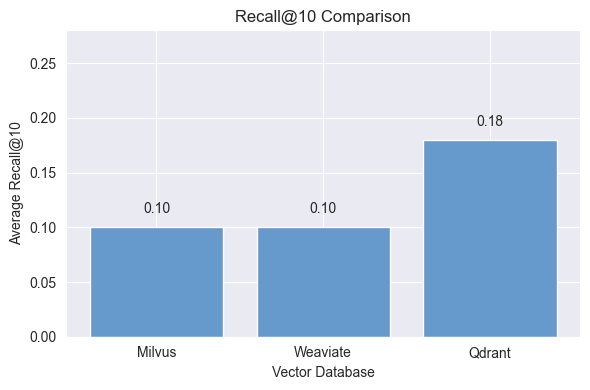

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# === Data ===
dbs = ["Milvus", "Weaviate", "Qdrant"]

# Insert performance
insert_throughput = [585.32, 62.06, 122.07]  # docs/sec
insert_latency = [1.70, 0.0154, 8.08]        # seconds

# ANN performance
ann_throughput = [85.97, 58.52, 15.45]       # q/s
ann_latency = [11.63, 17.09, 64.71]          # ms
ann_recall = [0.10, 0.10, 0.18]

# Common x setup
x = np.arange(len(dbs))
width = 0.35

# === 1. Insert Performance ===
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(x - width/2, insert_throughput, width, label="Throughput (docs/sec)", color="#66b3ff")
ax2 = ax1.twinx()
ax2.bar(x + width/2, insert_latency, width, label="Latency (s)", color="#ff9999")

ax1.set_xlabel("Vector Database")
ax1.set_ylabel("Throughput (docs/sec)", color="#66b3ff")
ax2.set_ylabel("Latency (s)", color="#ff9999")
ax1.set_title("Insert Performance Comparison")
ax1.set_xticks(x)
ax1.set_xticklabels(dbs)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

# === 2. ANN Performance (Throughput & Latency) ===
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(x - width/2, ann_throughput, width, label="Throughput (q/s)", color="#99e699")
ax2 = ax1.twinx()
ax2.bar(x + width/2, ann_latency, width, label="Latency (ms)", color="#ffcc66")

ax1.set_xlabel("Vector Database")
ax1.set_ylabel("Throughput (q/s)", color="#66cc66")
ax2.set_ylabel("Latency (ms)", color="#ff9933")
ax1.set_title("ANN Search Performance Comparison")
ax1.set_xticks(x)
ax1.set_xticklabels(dbs)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

# === 3. Recall@10 Comparison ===
plt.figure(figsize=(6, 4))
plt.bar(dbs, ann_recall, color="#6699cc")
plt.title("Recall@10 Comparison")
plt.xlabel("Vector Database")
plt.ylabel("Average Recall@10")
plt.ylim(0, max(ann_recall) + 0.1)

# Add recall values above bars
for i, r in enumerate(ann_recall):
    plt.text(i, r + 0.01, f"{r:.2f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\erict\AppData\Local\Temp\ipykernel_19840\4128432579.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Dataset Size"] = df["Dataset"].replace({"1K": 1_000, "100K": 100_000})


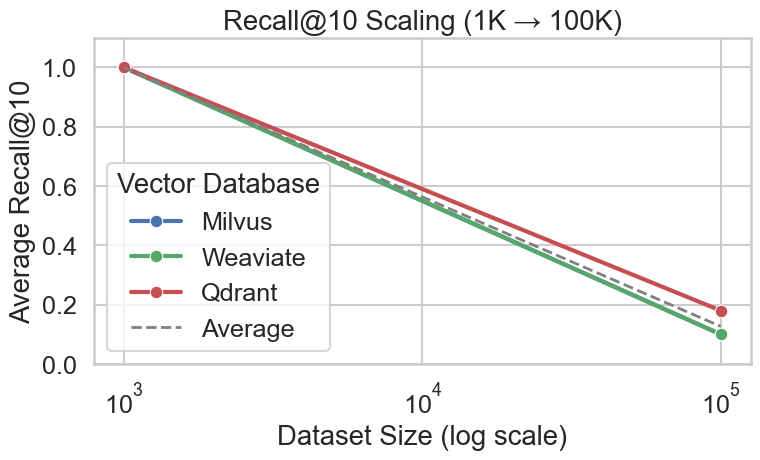

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Data Preparation ===
data = [
    ["Milvus", "1K", 1.00],
    ["Weaviate", "1K", 1.00],
    ["Qdrant", "1K", 1.00],
    ["Milvus", "100K", 0.10],
    ["Weaviate", "100K", 0.10],
    ["Qdrant", "100K", 0.18],
]

df = pd.DataFrame(data, columns=["Database", "Dataset", "Recall@10"])
df["Dataset Size"] = df["Dataset"].replace({"1K": 1_000, "100K": 100_000})

# Compute average recall per dataset
avg_recall = df.groupby("Dataset Size")["Recall@10"].mean()

# === Visualization Settings ===
sns.set(style="whitegrid", context="talk", font_scale=1.1)
palette = {"Milvus": "#4c72b0", "Weaviate": "#55a868", "Qdrant": "#c44e52"}

# === Plot: Recall Scaling ===
plt.figure(figsize=(8,5))
sns.lineplot(data=df, x="Dataset Size", y="Recall@10", hue="Database",
             marker="o", linewidth=3, palette=palette)
plt.plot(avg_recall.index, avg_recall.values, color="gray", linestyle="--", linewidth=2, label="Average")

plt.xscale("log")
plt.ylim(0, 1.1)
plt.title("Recall@10 Scaling (1K → 100K)")
plt.ylabel("Average Recall@10")
plt.xlabel("Dataset Size (log scale)")
plt.legend(title="Vector Database", loc="best")
plt.tight_layout()
plt.show()
